In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vgg19:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F6303%2F9897%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T101853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4242dc6e34caf715b4e214f37e169adc50847d429ca5bfbb7fd83b426f0f0715af45f7461a30efc173ac403a2822c8ea6535a908eead9af621d0527c0f3286b61dc4ab9ac7661b0b7ea3713f2ff383ba6d7cef0e7667d51d8431b1fbc8b20ec49ddb5a104428c4df75b2d9b81649565160c3306bd3fc12276ef825eb21c8a7120037705e8b32a4b57d5b0064dabde40f2b22393065307457dec9ab762491e2513dbb6b6ad763394714723c5705fc7ec71e94c353ee794dc34380eb5bf81b07aaf5cf9e5254c235fee6654c8a370449b3354b215d8da446c4f49e999f9fb06939aad3933aafdf59f120ed4448c134a2b369d2dd9823c25943ab3180d5bc0835f5,image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F55098%2F107188%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T101853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8178834d3f32dac6badbaa2764a70f7ca9172a39e48a4d707c2fd01e2f72a70476fefcac70f1f862363ae8ca250777e959f779292d01374524787815d7999a2464ad739b8d952f8503088ac21d066b0ef7840ab16523e9ef456fd4a94635dafdf5ae417a7eee08d0a0229d1c8db0d016c7bb93b4ccf45690cdb1b965f459c6b772cceb383050284451d5725eb71802a01af3ebec2302d4eb00d322bd9ad425ad5b6ec6205cbf187883173f85b4e3d5d6276f3d5f585042bbce706951200042d401e2ef6fc829a280a21ed885b8aa7e3818ac68df32285c2bd1ae691da76bbb1a74cd40cc569886e84b68dab4cfa6783794a14db565922f6003755fd9f81cc1e9,best-artworks-of-all-time:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F130081%2F310927%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T101853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D96303a59c869a39d8dbf9ec592597cdc856a703ccd7f2cef8e3b2c1e116e0ff56ca3646cdc3726427a6fc274ec65fc6d4db1aeb8e2166f69f8c65d54554b9caffe9ca3aa76ca5b6fa27d57c592f0958e8b52198a9cde828322c9bda446960e4ad836885f5bc983c01179f425f087676a27b103908b6a82316a3906478edfd6240d155d64ba71b4c3cd8e7bc308e68ae1ad5ab866ee0db1f3ee619608bc6fca247820f2d65beb0cb80f32fb982a36395a4516363abed9c3b36d675936f80fc02a871fc80ded08ed07d3f5454d43ab4220660738a19f629b6c79ae41a79287637332d6c2590d3dec30aeadf643362eb89d7abcd56c09d8fc0f4ad8a91aadcba8ed'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 608000438 bytes downloaded
Downloaded and uncompressed: vgg19
[==================================================] 2514186873 bytes downloaded
Downloaded and uncompressed: image-classification
[==================================================] 2460161668 bytes downloaded
Downloaded and uncompressed: best-artworks-of-all-time
Data source import complete.


# NEURAL STYLE TRANSFER algorithm

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['vgg19', 'best-artworks-of-all-time', 'image-classification']


In [ ]:
StylePath = '../input/best-artworks-of-all-time/images/images/'
ContentPath = '../input/image-classification/validation/validation/travel and adventure/'

## Loading the path for Base Content Image and the Style image respectively

In [ ]:
base_image_path = ContentPath+'2.jpg'
style_image_path = StylePath+'Pablo_Picasso/Pablo_Picasso_102.jpg'

In [ ]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## This function is used to Preprocess the image with help of VGG19.


In [ ]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

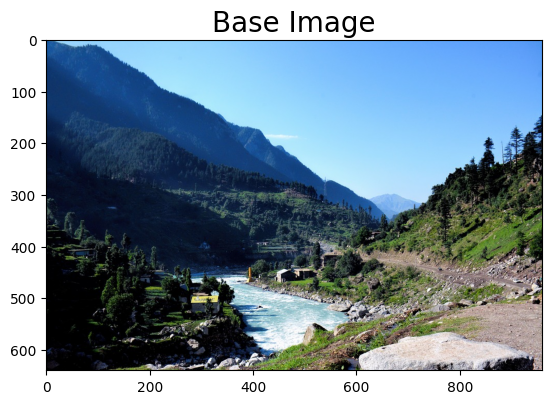

In [ ]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(ContentPath+'2.jpg')
plt.imshow(img1)

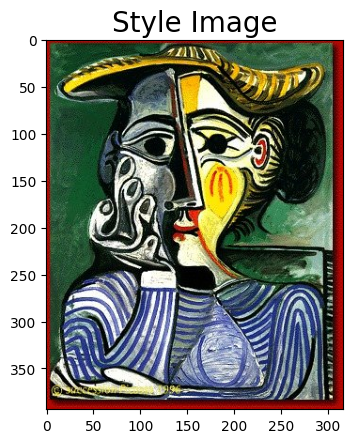

In [ ]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(StylePath+'Pablo_Picasso/Pablo_Picasso_102.jpg')
plt.imshow(img1)

In [ ]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [ ]:
K.image_data_format()

'channels_last'

### this will contain our generated image

Think of **Variable** in tensorflow as a normal variables which we use in programming languages. We initialize variables, we can modify it later as well. Whereas **placeholder** doesn’t require initial value. Placeholder simply allocates block of memory for future use. Later, we can use feed_dict to feed the data into placeholder. By default, placeholder has an unconstrained shape, which allows you to feed tensors of different shapes in a session.

In [ ]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

  <tf.Variable 'Variable:0' shape=(1, 400, 600, 3) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


## Building the VGG19 model

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


Model loaded.


## Athough Vgg19 is basically used for Classification purpose, but here our objective is not to classify rather our objective is to transform a image, so we do not need all the layers of vgg19, we have specially excluded those layers which are used for classification.

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

KerasTensor(type_spec=TensorSpec(shape=(3, 25, 37, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")


## The content Loss


In [ ]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

## The Style Loss


In [ ]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))


In [ ]:
#Get output layers corresponding to style and content layers
style_outputs = [model.get_layer(name).output for name in style_layers]
content_outputs = [model.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

In [ ]:
#Get the style and content feature representations from our model
style_features = [style_layer[0] for style_layer in model_outputs[:num_style_layers]]
content_features = [content_layer[1] for content_layer in model_outputs[num_style_layers:]]

In [ ]:
 gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

In [ ]:
style_output_features = model_outputs[:num_style_layers]
content_output_features = model_outputs[num_style_layers:]
#Accumulate style losses from all layers
#Here, we equally weight each contribution of each loss layer
weight_per_style_layer = 1.0 / float(num_style_layers)
loss = K.variable(0.0)
style_score = 0
content_score = 0

for target_style, comb_style in zip(gram_style_features, style_output_features):
  style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
#Accumulate content losses from all layers
weight_per_content_layer = 1.0 / float(num_content_layers)
for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

style_score *= style_weight
content_score *= content_weight

#Get total loss
loss = style_score + content_score

In [ ]:
content_weight=0.025
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 33, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(25, 33, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(25, 33, 512), dtype=float32)

WARNING:tensorflow:Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.
Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 535, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 535, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 535, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 267, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 267, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 267, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 133, 256), dtype=float32)
Style Image Feature :: Tensor("strided_slice_10:0", shape=(100, 133, 256), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_11:0", shape=(100, 133, 256), dtype=float32)

Layer Feature for Style Layers :: Tensor("block4_conv1/Relu:0", shape=(3, 50, 66, 512), dtype=float32)
Style Image Feature :: Tensor("strided_slice_14:0", shape=(50, 66, 512), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_15:0", shape=(50, 66, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block5_conv1/Relu:0", shape=(3, 25, 33, 512), dtype=float32)
Style Image Feature :: Tensor("strided_slice_18:0", shape=(25, 33, 512), dtype=float32)

## Features are extracted from each layer in style layers and content layers and their overall loss is calculated from it...

### This deprocess_image function is used return the original format of the Final image  after transformation which could be easily read and displayed by Matplotlib.

In [ ]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Calculation of gradient with respect to loss..

In [ ]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 535, 3) dtype=float32>]

In [ ]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

<keras.backend.tensorflow_backend.Function at 0x7f380b4c4b00>

**Athough there are various optimizers but we have used L-BFGS optimizer in this case, I have also gone through research papers where they have used ADAM optimizer to optimize the loss and get the final image.**

In [ ]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [ ]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


The purpose of this **Evaluator** class is to avoid the error **'numpy.ndarray' object is not callable error with optimize.minimize** while running the L-BFGS optimizer for loss minimization.<br><br>
You should pass the function itself to minimize, instead of a evaluated value.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:
evaluator = Evaluator()

In [ ]:
iterations=400
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss,
                                        x_opt.flatten(),
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss.
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0

Current loss value: 4.9363466e+21

Start of iteration 1

Current loss value: 2.198678e+21


Start of iteration 2

Current loss value: 1.4066466e+21

Start of iteration 3

Current loss value: 1.07629304e+21

Start of iteration 4

Current loss value: 8.637763e+20

Start of iteration 5

Current loss value: 7.333195e+20

Start of iteration 6

Current loss value: 6.343845e+20

Start of iteration 7

Current loss value: 5.6636414e+20

Start of iteration 8

Current loss value: 5.1390136e+20

Start of iteration 9

Current loss value: 4.697767e+20

Start of iteration 10

Current loss value: 4.366605e+20

Start of iteration 11

Current loss value: 4.0819754e+20

Start of iteration 12

Current loss value: 3.7960345e+20

Start of iteration 13

Current loss value: 3.557682e+20

Start of iteration 14

Current loss value: 3.3625536e+20

Start of iteration 15

Current loss value: 3.1911406e+20

Start of iteration 16

Current loss value: 3.057674e+20

Start of iteration 17

Current loss value: 2.9211892e+20

Start of iteration 18

Current loss value: 2.7968499e+20

Start of iteration 19

Current loss value: 2.6841199e+20

Start of iteration 20

Current loss value: 2.5811152e+20

Start of iteration 21

Current loss value: 2.4886816e+20

Start of iteration 22

Current loss value: 2.411035e+20

Start of iteration 23

Current loss value: 2.3426818e+20

Start of iteration 24

Current loss value: 2.2770856e+20

Start of iteration 25

Current loss value: 2.1952e+20

Start of iteration 26

Current loss value: 2.118352e+20

Start of iteration 27

Current loss value: 2.0596789e+20

Start of iteration 28

Current loss value: 1.999458e+20

Start of iteration 29

Current loss value: 1.945457e+20

Start of iteration 30

Current loss value: 1.8940564e+20

Start of iteration 31

Current loss value: 1.8498922e+20

Start of iteration 32

Current loss value: 1.8120652e+20

Start of iteration 33

Current loss value: 1.7629636e+20

Start of iteration 34

Current loss value: 1.7179336e+20

Start of iteration 35

Current loss value: 1.6721447e+20

Start of iteration 36

Current loss value: 1.6359597e+20

Start of iteration 37

Current loss value: 1.6086972e+20

Start of iteration 38

Current loss value: 1.5821812e+20

Start of iteration 39

Current loss value: 1.5493289e+20

Start of iteration 40

Current loss value: 1.524967e+20

Start of iteration 41

Current loss value: 1.4842126e+20

Start of iteration 42

Current loss value: 1.4534123e+20

Start of iteration 43

Current loss value: 1.4283123e+20

Start of iteration 44

Current loss value: 1.406387e+20

Start of iteration 45

Current loss value: 1.3885166e+20

Start of iteration 46

Current loss value: 1.37210475e+20

Start of iteration 47

Current loss value: 1.3447464e+20

Start of iteration 48

Current loss value: 1.3231678e+20

Start of iteration 49

Current loss value: 1.3082071e+20

Start of iteration 50

Current loss value: 1.294202e+20

Start of iteration 51

Current loss value: 1.2791274e+20

Start of iteration 52

Current loss value: 1.2631726e+20

Start of iteration 53

Start of iteration 54


Current loss value: 1.23089605e+20

Start of iteration 55

Current loss value: 1.2110161e+20

Start of iteration 56

Current loss value: 1.1818676e+20

Start of iteration 57

Current loss value: 1.15673655e+20

Start of iteration 58

Current loss value: 1.1447074e+20

Start of iteration 59

Current loss value: 1.1316408e+20

Start of iteration 60

Current loss value: 1.12150336e+20

Start of iteration 61

Current loss value: 1.1121649e+20

Start of iteration 62

Current loss value: 1.0979155e+20

Start of iteration 63

Current loss value: 1.0855757e+20

Start of iteration 64

Current loss value: 1.0719216e+20

Start of iteration 65

Current loss value: 1.0611748e+20

Start of iteration 66

Current loss value: 1.0467123e+20

Start of iteration 67

Current loss value: 1.0347366e+20

Start of iteration 68

Current loss value: 1.0262512e+20

Start of iteration 69

Current loss value: 1.0177309e+20

Start of iteration 70

Current loss value: 1.0094184e+20

Start of iteration 71

Current loss value: 9.9968494e+19

Start of iteration 72

Current loss value: 9.914116e+19

Start of iteration 73

Current loss value: 9.806568e+19

Start of iteration 74

Current loss value: 9.701643e+19

Start of iteration 75

Current loss value: 9.62161e+19

Start of iteration 76

Current loss value: 9.536757e+19

Start of iteration 77

Current loss value: 9.464101e+19

Start of iteration 78

Current loss value: 9.398139e+19

Start of iteration 79

Current loss value: 9.33626e+19

Start of iteration 80

Current loss value: 9.271237e+19

Start of iteration 81

Current loss value: 9.206945e+19

Start of iteration 82

Current loss value: 9.146329e+19

Start of iteration 83

Current loss value: 9.095776e+19

Start of iteration 84

Current loss value: 9.0343845e+19

Start of iteration 85

Current loss value: 8.973374e+19

Start of iteration 86

Current loss value: 8.920678e+19

Start of iteration 87

Current loss value: 8.811184e+19

Start of iteration 88

Current loss value: 8.718921e+19

Start of iteration 89

Current loss value: 8.660235e+19

Start of iteration 90

Current loss value: 8.603804e+19

Start of iteration 91

Current loss value: 8.5181435e+19

Start of iteration 92

Current loss value: 8.435163e+19

Start of iteration 93

Current loss value: 8.387558e+19

Start of iteration 94

Current loss value: 8.32894e+19

Start of iteration 95

Current loss value: 8.277535e+19

Start of iteration 96

Current loss value: 8.231625e+19

Start of iteration 97

Current loss value: 8.1883815e+19

Start of iteration 98

Current loss value: 8.138638e+19

Start of iteration 99

Current loss value: 8.0858595e+19

Start of iteration 100

Current loss value: 8.029708e+19

Start of iteration 101

Current loss value: 7.9712095e+19

Start of iteration 102

Current loss value: 7.911055e+19

Start of iteration 103

Current loss value: 7.858806e+19

Start of iteration 104

Current loss value: 7.803276e+19

Start of iteration 105

Current loss value: 7.7566745e+19

Start of iteration 106

Current loss value: 7.702627e+19

Start of iteration 107

Current loss value: 7.642664e+19

Start of iteration 108

Current loss value: 7.591631e+19

Start of iteration 109

Current loss value: 7.5417675e+19

Start of iteration 110

Current loss value: 7.4958546e+19

Start of iteration 111

Current loss value: 7.458384e+19

Start of iteration 112

Current loss value: 7.423556e+19

Start of iteration 113

Current loss value: 7.385928e+19

Start of iteration 114

Current loss value: 7.3464863e+19

Start of iteration 115

Current loss value: 7.278036e+19

Start of iteration 116

Current loss value: 7.223253e+19

Start of iteration 117

Current loss value: 7.1853494e+19

Start of iteration 118

Current loss value: 7.150449e+19

Start of iteration 119

Current loss value: 7.1043057e+19

Start of iteration 120

Current loss value: 7.066604e+19

Start of iteration 121

Current loss value: 7.0379845e+19

Start of iteration 122

Current loss value: 7.0125875e+19

Start of iteration 123

Current loss value: 6.9849555e+19

Start of iteration 124

Current loss value: 6.9563123e+19

Start of iteration 125

Current loss value: 6.9264144e+19

Start of iteration 126

Current loss value: 6.8953303e+19

Start of iteration 127

Current loss value: 6.8697583e+19

Start of iteration 128

Current loss value: 6.8418483e+19

Start of iteration 129

Current loss value: 6.8139594e+19

Start of iteration 130

Current loss value: 6.7889148e+19

Start of iteration 131

Current loss value: 6.763386e+19

Start of iteration 132

Current loss value: 6.73755e+19

Start of iteration 133

Current loss value: 6.7124464e+19

Start of iteration 134

Current loss value: 6.6689343e+19

Start of iteration 135

Current loss value: 6.6260124e+19

Start of iteration 136

Current loss value: 6.6003696e+19

Start of iteration 137

Current loss value: 6.575527e+19

Start of iteration 138

Current loss value: 6.5481934e+19

Start of iteration 139

Current loss value: 6.5209906e+19

Start of iteration 140

Current loss value: 6.488176e+19

Start of iteration 141

Current loss value: 6.450603e+19

Start of iteration 142

Current loss value: 6.4184713e+19

Start of iteration 143

Current loss value: 6.3896372e+19

Start of iteration 144

Current loss value: 6.369066e+19

Start of iteration 145

Current loss value: 6.3458494e+19

Start of iteration 146

Current loss value: 6.3143018e+19

Start of iteration 147

Current loss value: 6.2833914e+19

Start of iteration 148

Current loss value: 6.2464267e+19

Start of iteration 149

Current loss value: 6.211409e+19

Start of iteration 150

Current loss value: 6.1774376e+19

Start of iteration 151

Current loss value: 6.1485513e+19

Start of iteration 152

Current loss value: 6.1195884e+19

Start of iteration 153

Current loss value: 6.085438e+19

Start of iteration 154

Current loss value: 6.0645266e+19

Start of iteration 155

Current loss value: 6.0451857e+19

Start of iteration 156

Current loss value: 6.0260806e+19

Start of iteration 157

Current loss value: 6.0077738e+19

Start of iteration 158

Current loss value: 5.9897264e+19

Start of iteration 159

Current loss value: 5.9739264e+19

Start of iteration 160

Current loss value: 5.9571144e+19

Start of iteration 161

Current loss value: 5.939944e+19

Start of iteration 162

Current loss value: 5.9238287e+19

Start of iteration 163

Current loss value: 5.905736e+19

Start of iteration 164

Current loss value: 5.8870733e+19

Start of iteration 165

Current loss value: 5.869766e+19

Start of iteration 166

Current loss value: 5.849601e+19

Start of iteration 167

Current loss value: 5.83089e+19

Start of iteration 168

Current loss value: 5.8116547e+19

Start of iteration 169

Current loss value: 5.7922585e+19

Start of iteration 170

Current loss value: 5.771136e+19

Start of iteration 171

Current loss value: 5.750413e+19

Start of iteration 172

Current loss value: 5.719961e+19

Start of iteration 173

Current loss value: 5.6923595e+19

Start of iteration 174

Current loss value: 5.676376e+19

Start of iteration 175

Current loss value: 5.660617e+19

Start of iteration 176

Current loss value: 5.6457116e+19

Start of iteration 177

Current loss value: 5.6276985e+19

Start of iteration 178

Current loss value: 5.6123955e+19

Start of iteration 179

Current loss value: 5.5993294e+19

Start of iteration 180

Current loss value: 5.5840237e+19

Start of iteration 181

Current loss value: 5.5713947e+19

Start of iteration 182

Current loss value: 5.5555424e+19

Start of iteration 183

Current loss value: 5.541026e+19

Start of iteration 184

Current loss value: 5.528656e+19

Start of iteration 185

Current loss value: 5.513436e+19

Start of iteration 186

Current loss value: 5.4967317e+19

Start of iteration 187

Current loss value: 5.4780515e+19

Start of iteration 188

Current loss value: 5.456188e+19

Start of iteration 189

Current loss value: 5.4315426e+19

Start of iteration 190

Current loss value: 5.4045566e+19

Start of iteration 191

Current loss value: 5.3862014e+19

Start of iteration 192

Current loss value: 5.3704885e+19

Start of iteration 193

Current loss value: 5.354825e+19

Start of iteration 194

Current loss value: 5.340698e+19

Start of iteration 195

Current loss value: 5.330411e+19

Start of iteration 196

Current loss value: 5.316944e+19

Start of iteration 197

Current loss value: 5.3036953e+19

Start of iteration 198

Current loss value: 5.2911508e+19

Start of iteration 199

Current loss value: 5.276078e+19

Start of iteration 200

Current loss value: 5.258763e+19

Start of iteration 201

Current loss value: 5.2433348e+19

Start of iteration 202

Current loss value: 5.227037e+19

Start of iteration 203

Current loss value: 5.2098036e+19

Start of iteration 204

Current loss value: 5.1889996e+19

Start of iteration 205

Current loss value: 5.1772427e+19

Start of iteration 206

Current loss value: 5.164824e+19

Start of iteration 207

Current loss value: 5.150701e+19

Start of iteration 208

Current loss value: 5.134815e+19

Start of iteration 209

Current loss value: 5.1152566e+19

Start of iteration 210

Current loss value: 5.0986395e+19

Start of iteration 211

Current loss value: 5.0846546e+19

Start of iteration 212

Current loss value: 5.070172e+19

Start of iteration 213

Current loss value: 5.053516e+19

Start of iteration 214

Current loss value: 5.034765e+19

Start of iteration 215

Current loss value: 5.0228387e+19

Start of iteration 216

Current loss value: 5.0121532e+19

Start of iteration 217

Current loss value: 5.003728e+19

Start of iteration 218

Current loss value: 4.9939783e+19

Start of iteration 219

Current loss value: 4.983156e+19

Start of iteration 220

Current loss value: 4.971977e+19

Start of iteration 221

Current loss value: 4.959949e+19

Start of iteration 222

Current loss value: 4.949072e+19

Start of iteration 223

Current loss value: 4.941226e+19

Start of iteration 224

Current loss value: 4.933478e+19

Start of iteration 225

Current loss value: 4.925608e+19

Start of iteration 226

Current loss value: 4.916663e+19

Start of iteration 227

Current loss value: 4.9058502e+19

Start of iteration 228

Current loss value: 4.895452e+19

Start of iteration 229

Current loss value: 4.8849485e+19

Start of iteration 230

Current loss value: 4.875875e+19

Start of iteration 231

Current loss value: 4.866421e+19

Start of iteration 232

Current loss value: 4.8576023e+19

Start of iteration 233

Current loss value: 4.848272e+19

Start of iteration 234

Current loss value: 4.8363475e+19

Start of iteration 235

Current loss value: 4.8258388e+19

Start of iteration 236

Current loss value: 4.816699e+19

Start of iteration 237

Current loss value: 4.808153e+19

Start of iteration 238

Current loss value: 4.7998e+19

Start of iteration 239

Current loss value: 4.7918977e+19

Start of iteration 240

Current loss value: 4.782842e+19

Start of iteration 241

Current loss value: 4.773256e+19

Start of iteration 242

Current loss value: 4.764291e+19

Start of iteration 243

Current loss value: 4.7568154e+19

Start of iteration 244

Current loss value: 4.7499716e+19

Start of iteration 245

Current loss value: 4.742466e+19

Start of iteration 246

Current loss value: 4.7344474e+19

Start of iteration 247

Current loss value: 4.7255923e+19

Start of iteration 248

Current loss value: 4.717392e+19

Start of iteration 249

Current loss value: 4.7098346e+19

Start of iteration 250

Current loss value: 4.7015262e+19

Start of iteration 251

Current loss value: 4.692007e+19

Start of iteration 252

Current loss value: 4.683999e+19

Start of iteration 253

Current loss value: 4.675088e+19

Start of iteration 254

Current loss value: 4.6672998e+19

Start of iteration 255

Current loss value: 4.6591533e+19

Start of iteration 256

Current loss value: 4.6521023e+19

Start of iteration 257

Current loss value: 4.644173e+19

Start of iteration 258

Current loss value: 4.6364593e+19

Start of iteration 259

Current loss value: 4.6282363e+19

Start of iteration 260

Current loss value: 4.619906e+19

Start of iteration 261

Current loss value: 4.6120937e+19

Start of iteration 262

Current loss value: 4.605204e+19

Start of iteration 263

Current loss value: 4.5968466e+19

Start of iteration 264

Current loss value: 4.588134e+19

Start of iteration 265

Current loss value: 4.580058e+19

Start of iteration 266

Current loss value: 4.5690514e+19

Start of iteration 267

Current loss value: 4.557199e+19

Start of iteration 268

Current loss value: 4.5439996e+19

Start of iteration 269

Current loss value: 4.53138e+19

Start of iteration 270

Current loss value: 4.522045e+19

Start of iteration 271

Current loss value: 4.513755e+19

Start of iteration 272

Current loss value: 4.505225e+19

Start of iteration 273

Current loss value: 4.49736e+19

Start of iteration 274

Current loss value: 4.490643e+19

Start of iteration 275

Current loss value: 4.4829803e+19

Start of iteration 276

Current loss value: 4.4756324e+19

Start of iteration 277

Current loss value: 4.4686044e+19

Start of iteration 278

Current loss value: 4.461804e+19

Start of iteration 279

Current loss value: 4.453643e+19

Start of iteration 280

Current loss value: 4.444376e+19

Start of iteration 281

Current loss value: 4.4341756e+19

Start of iteration 282

Current loss value: 4.4246604e+19

Start of iteration 283

Current loss value: 4.4143488e+19

Start of iteration 284

Current loss value: 4.4082385e+19

Start of iteration 285

Current loss value: 4.401939e+19

Start of iteration 286

Current loss value: 4.395773e+19

Start of iteration 287

Current loss value: 4.387635e+19

Start of iteration 288

Current loss value: 4.3809346e+19

Start of iteration 289

Current loss value: 4.373243e+19

Start of iteration 290

Current loss value: 4.366948e+19

Start of iteration 291

Current loss value: 4.3612832e+19

Start of iteration 292

Current loss value: 4.35523e+19

Start of iteration 293

Current loss value: 4.348703e+19

Start of iteration 294

Current loss value: 4.3421737e+19

Start of iteration 295

Current loss value: 4.335705e+19

Start of iteration 296

Current loss value: 4.3284356e+19

Start of iteration 297

Current loss value: 4.321922e+19

Start of iteration 298

Current loss value: 4.315893e+19

Start of iteration 299

Current loss value: 4.310291e+19

Start of iteration 300

Current loss value: 4.304307e+19

Start of iteration 301

Current loss value: 4.298581e+19

Start of iteration 302

Current loss value: 4.292517e+19

Start of iteration 303

Current loss value: 4.28687e+19

Start of iteration 304

Current loss value: 4.281272e+19

Start of iteration 305

Current loss value: 4.2761177e+19

Start of iteration 306

Current loss value: 4.270439e+19

Start of iteration 307

Current loss value: 4.264851e+19

Start of iteration 308

Current loss value: 4.2581583e+19

Start of iteration 309

Current loss value: 4.2534277e+19

Start of iteration 310

Current loss value: 4.247976e+19

Start of iteration 311

Current loss value: 4.2426657e+19

Start of iteration 312

Current loss value: 4.236971e+19

Start of iteration 313

Current loss value: 4.231853e+19

Start of iteration 314

Current loss value: 4.226205e+19

Start of iteration 315

Current loss value: 4.2212107e+19

Start of iteration 316

Current loss value: 4.2151392e+19

Start of iteration 317

Current loss value: 4.2083574e+19

Start of iteration 318

Current loss value: 4.1998266e+19

Start of iteration 319

Current loss value: 4.193866e+19

Start of iteration 320

Current loss value: 4.1871593e+19

Start of iteration 321

Current loss value: 4.1811665e+19

Start of iteration 322

Current loss value: 4.1745246e+19

Start of iteration 323

Current loss value: 4.168892e+19

Start of iteration 324

Current loss value: 4.1627224e+19

Start of iteration 325

Current loss value: 4.1579004e+19

Start of iteration 326

Current loss value: 4.1530063e+19

Start of iteration 327

Current loss value: 4.148404e+19

Start of iteration 328

Current loss value: 4.143048e+19

Start of iteration 329

Current loss value: 4.1380116e+19

Start of iteration 330

Current loss value: 4.1316225e+19

Start of iteration 331

Current loss value: 4.1251926e+19

Start of iteration 332

Current loss value: 4.118598e+19

Start of iteration 333

Current loss value: 4.1128213e+19

Start of iteration 334

Current loss value: 4.1065493e+19

Start of iteration 335

Current loss value: 4.1010856e+19

Start of iteration 336

Current loss value: 4.0948958e+19

Start of iteration 337

Current loss value: 4.090578e+19

Start of iteration 338

Current loss value: 4.0862426e+19

Start of iteration 339

Current loss value: 4.0819484e+19

Start of iteration 340

Current loss value: 4.077696e+19

Start of iteration 341

Current loss value: 4.0735595e+19

Start of iteration 342

Current loss value: 4.0693202e+19

Start of iteration 343

Current loss value: 4.065094e+19

Start of iteration 344

Current loss value: 4.0612445e+19

Start of iteration 345

Current loss value: 4.0570374e+19

Start of iteration 346

Current loss value: 4.051433e+19

Start of iteration 347

Current loss value: 4.045995e+19

Start of iteration 348

Current loss value: 4.0414784e+19

Start of iteration 349

Current loss value: 4.037022e+19

Start of iteration 350

Current loss value: 4.031865e+19

Start of iteration 351

Current loss value: 4.0256037e+19

Start of iteration 352

Current loss value: 4.020109e+19

Start of iteration 353

Current loss value: 4.0139963e+19

Start of iteration 354

Current loss value: 4.0077916e+19

Start of iteration 355

Current loss value: 4.002084e+19

Start of iteration 356

Current loss value: 3.9959446e+19

Start of iteration 357

Current loss value: 3.9895867e+19

Start of iteration 358

Current loss value: 3.9858084e+19

Start of iteration 359

Current loss value: 3.9811236e+19

Start of iteration 360

Current loss value: 3.9775348e+19

Start of iteration 361

Current loss value: 3.9733707e+19

Start of iteration 362

Current loss value: 3.969313e+19

Start of iteration 363

Current loss value: 3.965067e+19

Start of iteration 364

Current loss value: 3.960858e+19

Start of iteration 365

Current loss value: 3.956749e+19

Start of iteration 366

Current loss value: 3.952085e+19

Start of iteration 367

Current loss value: 3.9480516e+19

Start of iteration 368

Current loss value: 3.943195e+19

Start of iteration 369

Current loss value: 3.9381907e+19

Start of iteration 370

Current loss value: 3.9335116e+19

Start of iteration 371

Current loss value: 3.92961e+19

Start of iteration 372

Current loss value: 3.925738e+19

Start of iteration 373

Current loss value: 3.9213093e+19

Start of iteration 374

Current loss value: 3.916321e+19

Start of iteration 375

Current loss value: 3.9118825e+19

Start of iteration 376

Current loss value: 3.906722e+19

Start of iteration 377

Current loss value: 3.902333e+19

Start of iteration 378

Current loss value: 3.8985287e+19

Start of iteration 379

Current loss value: 3.894845e+19

Start of iteration 380

Current loss value: 3.891243e+19

Start of iteration 381

Current loss value: 3.8874302e+19

Start of iteration 382

Current loss value: 3.883437e+19

Start of iteration 383

Current loss value: 3.8788158e+19

Start of iteration 384

Current loss value: 3.8745272e+19

Start of iteration 385

Current loss value: 3.869166e+19

Start of iteration 386

Current loss value: 3.8643264e+19

Start of iteration 387

Current loss value: 3.8589894e+19

Start of iteration 388

Current loss value: 3.854828e+19

Start of iteration 389

Current loss value: 3.8498806e+19

Start of iteration 390

Current loss value: 3.8449095e+19

Start of iteration 391

Current loss value: 3.84046e+19

Start of iteration 392

Current loss value: 3.8361297e+19

Start of iteration 393

Current loss value: 3.8305406e+19

Start of iteration 394

Current loss value: 3.8268718e+19

Start of iteration 395

Current loss value: 3.821219e+19

Start of iteration 396

Current loss value: 3.8169392e+19

Start of iteration 397

Current loss value: 3.8125504e+19

Start of iteration 398

Current loss value: 3.808071e+19

Start of iteration 399

Current loss value: 3.8032653e+19

**The Final Image**

In [ ]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

<matplotlib.image.AxesImage at 0x7f3808d83e48>

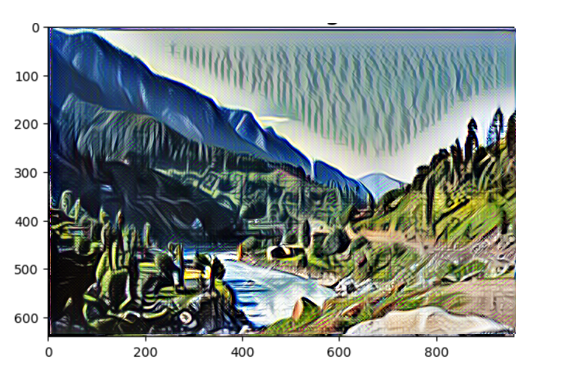

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)

<matplotlib.image.AxesImage at 0x7f3808e045f8>

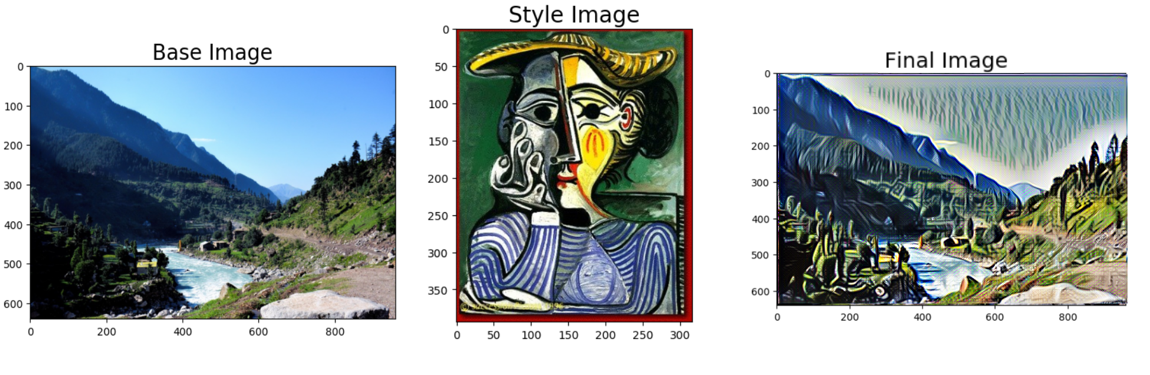

This function **Run_Style_Transfer** is nothing but combination of all the above code that is discussed in the above cells part by part. It returns the final image after style transfer between two images.

In [ ]:
def preprocess_image_instantiator(image_path,img_nrows,img_ncols):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
def Run_StyleTransfer(base_image_path, style_image_path):

    width, height = load_img(base_image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)

    base_image = K.variable(preprocess_image_instantiator(base_image_path,img_nrows,img_ncols))
    style_reference_image = K.variable(preprocess_image_instantiator(style_image_path,img_nrows,img_ncols))

    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1,3,img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1,img_nrows, img_ncols,3))

    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image
                                  ], axis=0)
    from keras.applications.vgg19 import VGG19
    vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model = VGG19(input_tensor=input_tensor,
                  include_top = False,
                  weights=vgg19_weights)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    content_weight=0.025
    style_weight=1.0
    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #print('Layer Feature for Content Layers :: '+str(layer_features))
    #print('Base Image Feature :: '+str(base_image_features))
    #print('Combination Image Feature for Content Layers:: '+str(combination_image_features))
    loss += content_weight * get_content_loss(base_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        #print('Layer Feature for Style Layers :: '+str(layer_features))
        #print('Style Image Feature :: '+str(style_reference_features))
        #print('Combination Image Feature for Style Layers:: '+str(combination_features))
        sl = get_style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl

    grads = K.gradients(loss, combination_image)

    outputs = [loss]
    if isinstance(grads, (list,tuple)):
        outputs += grads
    else:
        outputs.append(grads)
    f_outputs = K.function([combination_image], outputs)

    x_opt = preprocess_image(base_image_path)

    evaluator = Evaluator()
    iterations=200
    # Store our best result
    best_loss, best_img = float('inf'), None
    for i in range(iterations):
        #print('Start of iteration', i)
        x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss,
                                            x_opt.flatten(),
                                            fprime=evaluator.grads,
                                            maxfun=20,
                                            disp=True,
                                           )
        #print('Current loss value:', min_val)
        if min_val < best_loss:
            # Update best loss and best image from total loss.
            best_loss = min_val
            best_img = x_opt.copy()
    imgx = deprocess_image(best_img.copy())

    return imgx

In [ ]:
base_image_path_1 = '../input/image-classification/images/images/travel and  adventure/Places365_val_00005777.jpg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_1)
plt.imshow(img_base)

style_image_path_1 = '../input/best-artworks-of-all-time/images/images/Paul_Klee/Paul_Klee_96.jpg'
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_1)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imgg = Run_StyleTransfer(base_image_path_1, style_image_path_1)
plt.title("Final Image",fontsize=20)
plt.imshow(imgg)

WARNING:tensorflow:Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.

<matplotlib.image.AxesImage at 0x7f380b113978>

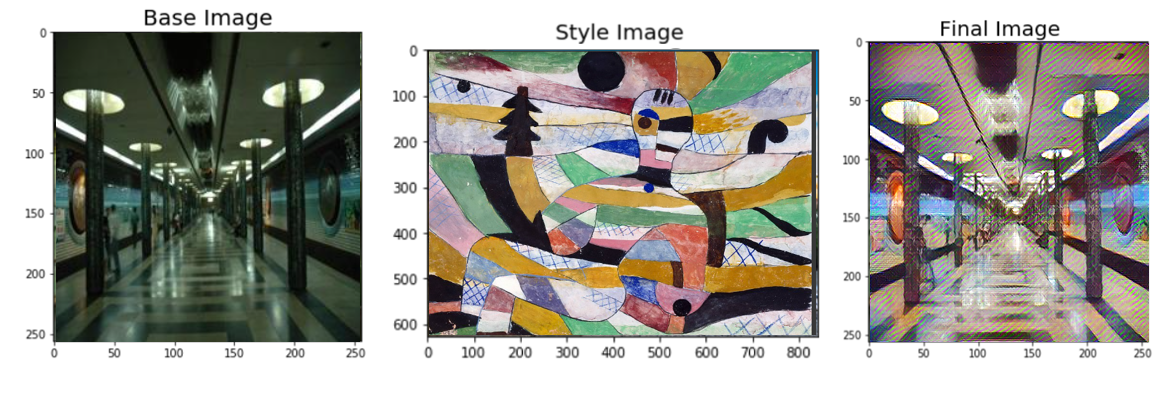

# Conclusion
* In our case the Final images formed are not totally perfect, because the Style image does not totally blend with the Base content image.
* It could be improved through icreasing the number of iteration, or by trying out a different syle transfer algorithm which could preseve the edges of the base image, or by trying out with different optimizer to minimize gradient and loss.